### Import libraries and define functions

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import stackstac
import planetary_computer
import pystac_client

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import xrspatial.multispectral as ms
from xrspatial.convolution import calc_cellsize, circle_kernel, convolution_2d
from xrspatial.focal import mean, focal_stats, hotspots
from xrspatial.multispectral import true_color

from odc.stac import stac_load, configure_rio

from dask.distributed import Client, progress

# For unsupervised classifiaction
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
from sklearn.decomposition import PCA

import numpy as np

### Create empty array

In [4]:
def emptyArr (data, dBands):
    # create an empty array with same dimension and data type
    imgxyb = np.empty((len(data.y), len(data.x), len(dBands)),np.dtype(data[dBands[0]].to_numpy()[0][0]))

    # loop through the raster's bands to fill the empty array
    for band in range(imgxyb.shape[2]):
        imgxyb[:,:,band] = data[dBands[band]].to_numpy() 

    # convert to 1d array
    img1d=imgxyb[:,:,:len(dBands)].reshape((imgxyb.shape[0]*imgxyb.shape[1],imgxyb.shape[2]))
    
    return img1d

### Principle Componenet Analysis

In [5]:
def pcaFunc (data, dBands, nComp):
    # Create empty array
    img1d = emptyArr (data, dBands)

    pca = PCA(n_components=nComp)
    pca.fit(img1d)
    
    # print("Relative variance in principal components:", pca.explained_variance_ratio_)

    predict = pca.transform(img1d)
    predict_reshape = predict.reshape((len(data.y), len(data.x),nComp))
    
    for x in range(nComp):
        predicxr = xr.DataArray(predict_reshape[:,:,x], coords=data.coords, dims=data.dims, attrs=data.attrs)

        data[f'pca{x}'] = predicxr

### Segmentation analysis - K-Means Clustering (model)

In [6]:
def kmcFunc (data, dBands, nClus, cl_model, db, iDate):
    # Create empty array
    img1d = emptyArr (data, dBands)
    
    cl = cluster.KMeans(n_clusters=nClus) # create an object of the classifier
    param = cl.fit(img1d) # train it
    img_cl = cl.labels_ # get the labels of the classes
    img_cl = img_cl.reshape(len(data.y), len(data.x)) # reshape labels to a 3d array (one band only)
    data['kmc'] = xr.DataArray(img_cl, coords=data.coords, dims=data.dims, attrs=data.attrs)
    
    cl_model[f'kmc_mod_{iDate}'] = cl
    (unique, counts) = np.unique(data.kmc, return_counts=True)
    db[f'{iDate}'] = [unique, counts]

### Segmentation analysis - K-Means Clustering (prediction)

In [51]:
def kmcPred (data, dBands, model, db, iDate):
    # Create empty array
    img1d = emptyArr (data, dBands)
    # Select Kmc Model
    cl = model
    # predict the clusters in the image 
    pred = cl.predict(img1d)
    # reshape the 1d array predictions to x-y-bands shape order (only one band)
    img_cl = pred
    img_cl = img_cl.reshape(len(data.y), len(data.x))
    
    data['kmc_pred'] = xr.DataArray(img_cl, coords=data.coords, dims=data.dims, attrs=data.attrs)
    
    (unique, counts) = np.unique(data.kmc_pred, return_counts=True)
    db[f'{iDate}'] = [unique, counts]

### Colour ramp and RGB Plotting functions

In [8]:
# Plot with colourbar  
def pltCbar (axis, plot, minim, maxim, colors):#,title):
    divider = make_axes_locatable(axis)   
    cax = divider.append_axes('right', size='5%', pad=0.05)   
    im = axis.imshow(plot, vmin = minim, vmax = maxim, cmap = colors)  
    fig.colorbar(im, cax=cax, orientation='vertical')  
    #axis.set_title(title, fontsize=16, pad = 10)  
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)

#Plot mutlispectral image
def pltRGB (axis, plot):#,title):    
    im = axis.imshow(plot)   
    #axis.set_title(title, fontsize=16, pad = 10)    
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)

### Inititate client server and access stac catalog

In [9]:
client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


In [10]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Search STAC catologue for EO data

In [73]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
# bbox = [9.0376, 21.732, 9.0788, 21.768] # Airlit

# bbox = [11.5329, 21.7004, 11.5346, 21.7038] # Emma case 1

# bbox = [11.5557, 21.7028, 11.5854, 21.7445] # Emma case 2

# bbox = [11.4018, 22.0517, 11.4071, 22.0575] # Emma case 3

# bbox = [5.7948, 19.3984, 5.7979, 19.4023] # Miro Scrape

bbox = [34.0046, 11.4046, 34.0422, 11.4289] # Sudan 1

# Set a start and end date
start_date = "2018"
end_date = "2023"


In [74]:
search = catalog.search(
    collections=["sentinel-2-l2a"],
    # collections=["landsat-c2-l2"],
    bbox=bbox,
    # intersects=bbox,
    # datetime=time_of_interest,
    datetime=f"{start_date}-01-01/{end_date}-01-01",
    query={"eo:cloud_cover": {"lt": 10}} ,
)

# Check how many items were returned
items = search.item_collection()
print(f"Returned {len(items)} Items")

Returned 334 Items


### Load data from STAC

In [75]:
crs = "EPSG:32630"
resolution = 10

ds = stac_load(
    items,
    bands=("red", "green", "blue", "nir", "B11","B12"),
    # bands=("nir08", "red", "green", "blue", "qa_pixel", "swir16"),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    # stac_cfg=config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset>
Dimensions:      (y: 406, x: 554, time: 179)
Coordinates:
  * y            (y) float64 1.574e+06 1.574e+06 1.574e+06 ... 1.57e+06 1.57e+06
  * x            (x) float64 4.823e+06 4.823e+06 ... 4.828e+06 4.828e+06
    spatial_ref  int32 32630
  * time         (time) datetime64[ns] 2018-01-05T08:03:19.027000 ... 2022-12...
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>
    B11          (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 406, 554), meta=np.ndarray>

In [76]:
ds = ds.persist()

### Define bands for PCA analysis

In [77]:
xBands = ['red','green','blue','nir', 'B11', 'B12']
# xBands = ['red','green','blue','nir08', 'swir16']

### Yearly segmentation model

In [ ]:
yearly = ds.where(
    (ds['time.month'] < 6) | (ds['time.month'] > 11), drop=True).groupby('time.year').median().compute()

In [78]:
# yearly = ds.groupby("time.year").median().compute()
iYears = [x for x in np.arange(int(start_date),int(end_date),1)]

In [ ]:
kbands   = ['pca0']
cl_mod   = {}
pixCount = {}

# Define subplot shape (height, width)
plotShape = (2, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6*3,6*2))
# Define plot background colour
fig.patch.set_facecolor('white')

count = 0

for x in range(plotShape[0]):
    for y in range(plotShape[1]):
        if count+1 > len(iYears):
            continue
            
        year = (count+1)*-1
        # year = count
        
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        ax.set_axis_off()

        # Image date selection
        yImg  = yearly.sel(year=iYears[year])
        
        red   = yImg.red
        green = yImg.green
        blue  = yImg.blue
        # Describe image title
        title = f'{iYears[year]} Median test'

        # Generate rgb image
        # true_color_img = true_color(r=red, g=green, b=blue)
        # true_color_img.plot.imshow(ax=ax, vmin=150, vmax=250)
        
        if count == 0:  
            pcaFunc(yImg, xBands, 3)
        
            kmcFunc(yImg, kbands, 6, cl_mod, pixCount, iYears[year])
            
            title = f'{iYears[year]} KMC Model' 
            
            # pltCbar(ax,yImg.pca0,-2000, 2000, 'RdBu')
            pltCbar(ax,yImg.kmc,0, 4, 'RdBu')

        else:
            pcaFunc(yImg, xBands, 3)

            # kmcFunc(yImg, kbands, 5, cl_mod, pixCount, iYears[year])
            kmcPred (yImg, kbands, cl_mod[f'kmc_mod_{iYears[-1]}'], pixCount, iYears[year])
            # kmcPred (yImg, kbands, cl_mod[f'kmc_mod_{iYears[0]}'], pixCount, iYears[year])

            title = f'{iYears[year]} KMC Predicted'
            
            # pltCbar(ax,yImg.pca0,-2000,2000, 'RdBu')
            pltCbar(ax,yImg.kmc_pred,0, 4, 'RdBu')   
            # pltCbar(ax,yImg.kmc,0, 4, 'RdBu')
        
        ax.set_title(title,fontsize=18)
        
        count += 1
        
plt.tight_layout()

NameError: name 'plt' is not defined

### Plot trend in potentially mined areas. 

Text(0.5, 1.0, 'Mined area pixel count')

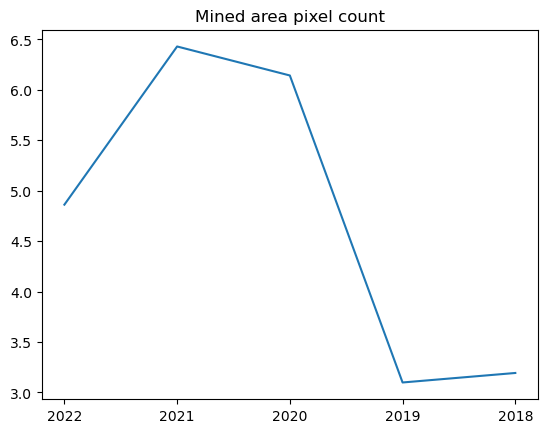

In [112]:
dData = [pixCount[x][1][0]/sum(pixCount[x][1])*100 for x in list(pixCount.keys())[::]if len(pixCount[x][1])==6]
dDates = [x for x in pixCount.keys() if len(pixCount[x][1])==6]
# plt.plot(list(pixCount.keys())[::], [pixCount[x][1][4]/sum(pixCount[x][1])*100 for x in list(pixCount.keys())[::]if len(pixCount[x][1])==5] )
plt.plot(dDates, dData )
# plt.ylim(3000, 9000)
plt.title('Mined area pixel count')

### Monthly mosaics

In [81]:
monthly = ds.groupby("time.month").median().compute()

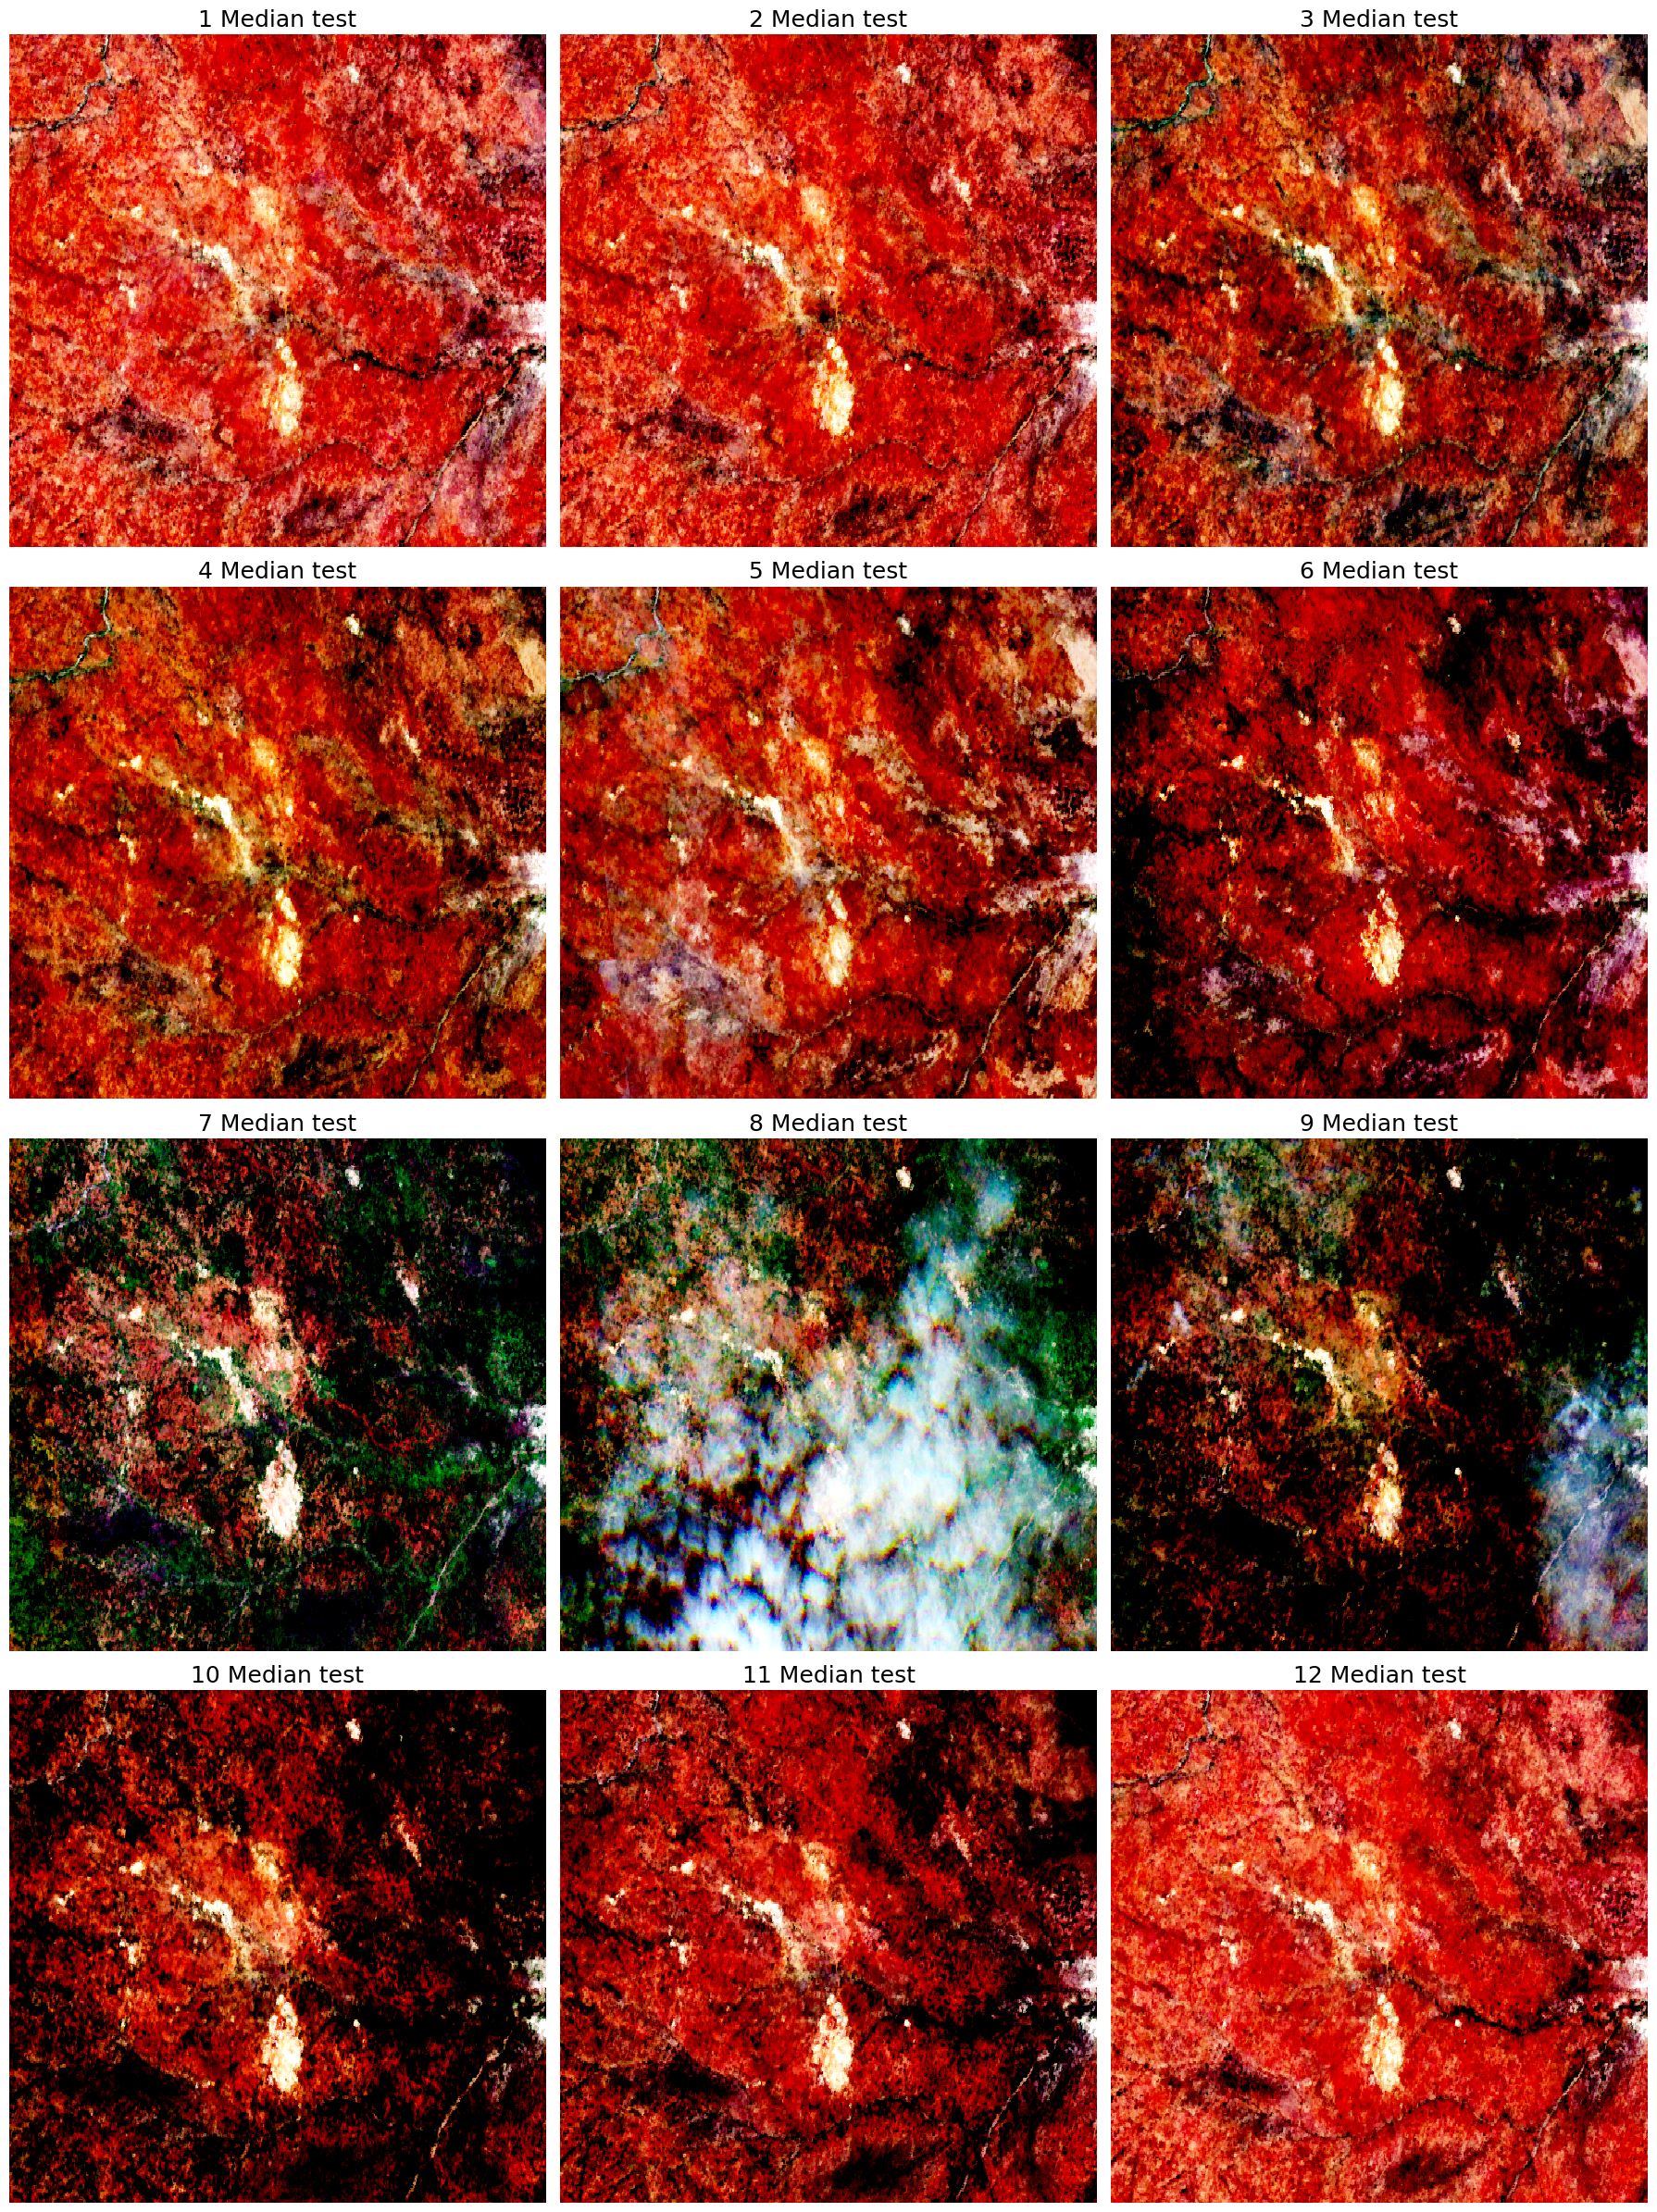

In [83]:
kbands   = ['pca0']
cl_mod   = {}
pixCount = {}

# Define subplot shape (height, width)
plotShape = (4, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6*3,6*4))
# Define plot background colour
fig.patch.set_facecolor('white')

iMonth = 1

for x in range(plotShape[0]):
    for y in range(plotShape[1]):
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        ax.set_axis_off()

        # Image date selection
        mImg  = monthly.sel(month=iMonth)
        
        red   = mImg.red
        green = mImg.green
        blue  = mImg.blue
        # Describe image title
        title = f'{iMonth} Median test'

        # Generate rgb image
        true_color_img = true_color(r=red, g=green, b=blue)
        true_color_img.plot.imshow(ax=ax, vmin=150, vmax=250)
        
        pcaFunc(mImg, xBands, 3)
        
        # pltCbar(ax,mImg.pca0,-2000, 2000, 'RdBu')
        
        ax.set_title(title,fontsize=18)
        
        iMonth += 1
        
plt.tight_layout()